# Transfer Learning with TensorFlow part 2: Fine-tuning

In [1]:
!nvidia-smi

Tue Jun  7 21:40:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we've created a bunch of helper function, let's use a helper.py file

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-07 21:40:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-07 21:40:21 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

We are going to use model from tf.keras.application

In [4]:
# Get 10% of training data of 10 classes of fod 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-06-07 21:40:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.147.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2022-06-07 21:40:27 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Checkout class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.21275520e+01 1.71275501e+01 1.41275511e+01]
   [2.92602043e+01 1.52602043e+01 1.22602043e+01]
   [3.19234695e+01 1.85663261e+01 1.53520403e+01]
   ...
   [3.85253181e+01 2.47548866e+01 2.44640999e+01]
   [4.79898338e+01 2.45611973e+01 2.87755089e+01]
   [5.67599564e+01 2.42037525e+01 3.24588432e+01]]

  [[3.07653046e+01 1.67653046e+01 1.37653065e+01]
   [3.20000000e+01 1.80000000e+01 1.50000000e+01]
   [3.11428566e+01 1.71428566e+01 1.41428566e+01]
   ...
   [4.98625221e+01 3.00053768e+01 3.09339485e+01]
   [5.10969162e+01 3.10867100e+01 3.20918121e+01]
   [1.15901176e+02 9.07838287e+01 9.38756638e+01]]

  [[2.82244892e+01 1.42244902e+01 1.12244902e+01]
   [2.93571434e+01 1.53571434e+01 1.23571434e+01]
   [2.95510197e+01 1.55510206e+01 1.25510206e+01]
   ...
   [4.48418617e+01 2.40255146e+01 3.02652721e+01]
   [8.64702835e+01 5.97967796e+01 6.53376007e+01]
   [1.95086792e+02 1.63015289e+02 1.69224472e+02]]

  ...

  [[6.00000000e+00 5.00000000e+00 1.00000000e+00]
   [6

## Model 0: Building a transfer learning feature extraction model using the Keras functional API

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [12]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# 2. Freeze the base model (Model's patterns won't be updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

# 4. If usinga model like ResNet50V2 you will need to normalize (don't have to for efficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs, training=False)
print(f"Shape after passing the inputs: {x.shape}")

# 6. Average the ouputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Create the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetb0")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing the inputs: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220607-214039
Epoch 1/5
24/24 [==============================] - 22s 269ms/step - loss: 1.8571 - accuracy: 0.4053 - val_loss: 1.3637 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 4s 153ms/step - loss: 1.1042 - accuracy: 0.7680 - val_loss: 0.9426 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 4s 154ms/step - loss: 0.7966 - accuracy: 0.8200 - val_loss: 0.7852 - val_accuracy: 0.7895
Epoch 4/5
24/24 [==============================] - 5s 186ms/step - loss: 0.6467 - accuracy: 0.8467 - val_loss: 0.6930 - val_accuracy: 0.8059
Epoch 5/5
24/24 [==============================] - 4s 154ms/step - loss: 0.5501 - accuracy: 0.8773 - val_loss: 0.6369 - val_accuracy: 0.8158


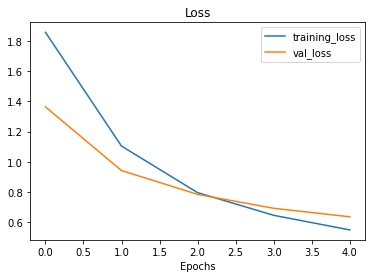

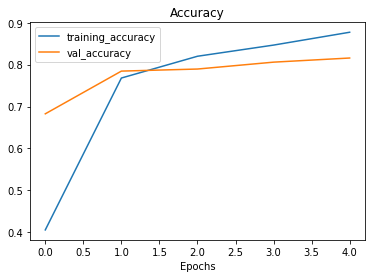

In [13]:
# Plot the loss curves
plot_loss_curves(history_0)

In [14]:
# Evaluate on the full test dataset
model_0.evaluate (test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.6039 - accuracy: 0.8444


[0.6038735508918762, 0.8443999886512756]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate (base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling2D layer

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor to the GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"GlobalAveragePooling2D tensor: \n {global_average_pooled_tensor}\n")

# Check the shapes of the tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of GlobalAveragePooling2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

GlobalAveragePooling2D tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of GlobalAveragePooling2D tensor: (1, 3)


In [19]:
# Pass the random tensor to the GlobalAveragePooling2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"GlobalMaxPooling2D tensor: \n {global_max_pooled_tensor}\n")

GlobalMaxPooling2D tensor: 
 [[0.9058464 1.1603122 1.6994323]]



## Running a series of transfer learning experiment

Let's try to experiment with 1% of the data

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4`use fine-tuning transfer learning with 100% of the data aith data augmentation

Note: We use the same test dataset everytime

### Getting and preprocessing data for model 1

In [20]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-06-07 21:41:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   104MB/s    in 1.2s    

2022-06-07 21:41:35 (104 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
unzip_data("10_food_classes_1_percent.zip")

In [22]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [23]:
# Create train and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` -> Augments the data on the GPU and it only happens during training, we can still save and use our model elsewhere

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name = "data_augmentation")

### Visualize our data augmentation layer and see what happens to our data

(-0.5, 544.5, 414.5, -0.5)

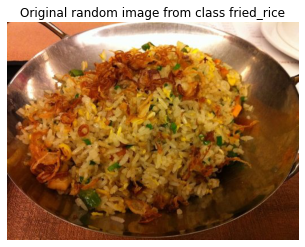

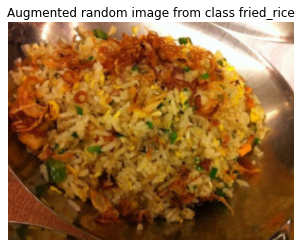

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [27]:
# Setup input shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation)
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20220607-214140
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4160 - accuracy: 0.1000 - val_loss: 2.2325 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1172 - accuracy: 0.3000 - val_loss: 2.1113 - val_accuracy: 0.2368
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9947 - accuracy: 0.3857 - val_loss: 2.0063 - val_accuracy: 0.2961
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8073 - accuracy: 0.5286 - val_loss: 1.9070 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6751 - accuracy: 0.6714 - val_loss: 1.8121 - val_accuracy: 0.4556


In [28]:
# Check out our model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

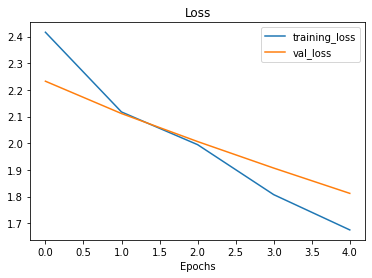

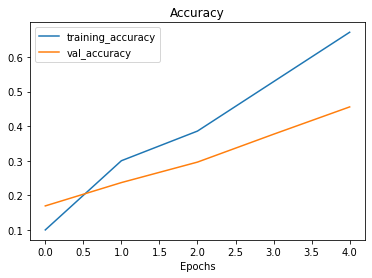

In [29]:
# Plot the loss curves
plot_loss_curves(history_1_percent)

In [30]:
# Evaluate on full test data
model_1.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 1.8288 - accuracy: 0.4420


[1.8288429975509644, 0.44200000166893005]

## Model 2: feature extraction transfer learning with data augmentation and 10% of the training data

### Creating a ModelCheckpoint callback

In [31]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [32]:
# Create a base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add the data augmentation layer
x = data_augmentation(inputs)

# Give the base model inputs
x = base_model(x, training=False)

# Add the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_10_percent_augmented = model_2.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[checkpoint_callback, create_tensorboard_callback("tensorflow_hub", "10_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20220607-214226
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0154 - accuracy: 0.3253WARNING:tensorflow:Model was constructed with shape (382, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(382, 512, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 682ms/step - loss: 2.0154 - accuracy: 0.3253 - val_loss: 1.5040 - val_accuracy: 0.6516
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3614 - accuracy: 0.6627
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 566ms/step - loss: 1.3614 - accuracy: 0.6627 - val_loss: 1.0513 - va

In [33]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.6861 - accuracy: 0.8116


[0.686126172542572, 0.8116000294685364]

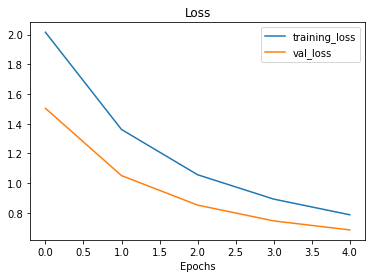

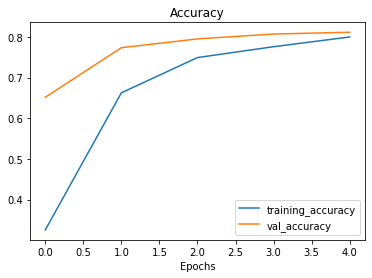

In [34]:
plot_loss_curves(history_10_percent_augmented)

### Loading in checkpointed wieghts

Loading in checkpointed weights returns a model ro a specific checkpoint

In [35]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [36]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6861 - accuracy: 0.8116


In [37]:
# If the results from our previously evaluated model2 match the loaded weights we have succeeded
loaded_weights_model_results

[0.6861259937286377, 0.8116000294685364]

## Model 3: Fine-tuning an existing model on 10% of the data

In [38]:
# Layers in our loaded model
model_2.layers

In [39]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb270f7d890> True
<keras.engine.sequential.Sequential object at 0x7fb275df3a10> True
<keras.engine.functional.Functional object at 0x7fb276189550> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb270f0a850> True
<keras.layers.core.dense.Dense object at 0x7fb276258710> True


In [40]:
# Check which layer is trainable in our functional layer
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [41]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [42]:
# To begin fin-tuning, let's start by setting the last 10 layers of our base model.trainable = True
base_model.trainable = True

# Freeze all layers expcept the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower the lr by 10x when fine-tuning
                metrics=["accuracy"])

In [43]:
# Check which layers a trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
# Now we've unfrozen some of the layers to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [45]:
# Fit the new model
history_10_percent_aug_fine_tuned = model_2.fit(train_data_10_percent,
                                                epochs=10,
                                                steps_per_epoch=len(train_data_10_percent),
                                                validation_data=test_data,
                                                validation_steps=int(0.25*len(test_data)),
                                                initial_epoch=history_10_percent_augmented.epoch[-1], # Start training from previous last epoch
                                                callbacks=[create_tensorboard_callback("tensorflow_hub", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tune_last_10/20220607-214416
Epoch 5/10
24/24 [==============================] - 20s 489ms/step - loss: 0.6998 - accuracy: 0.8000 - val_loss: 0.5436 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 8s 330ms/step - loss: 0.5512 - accuracy: 0.8373 - val_loss: 0.5084 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 9s 351ms/step - loss: 0.4662 - accuracy: 0.8560 - val_loss: 0.4830 - val_accuracy: 0.8388
Epoch 8/10
24/24 [==============================] - 9s 352ms/step - loss: 0.4257 - accuracy: 0.8613 - val_loss: 0.4653 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 9s 370ms/step - loss: 0.4169 - accuracy: 0.8653 - val_loss: 0.4310 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 8s 329ms/step - loss: 0.3510 - accuracy: 0.8933 - val_loss: 0.4731 - val_accuracy: 0.8273


In [46]:
# Evaluate the fine tuned model (model_3 or model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5009 - accuracy: 0.8240


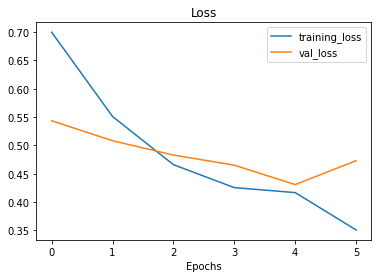

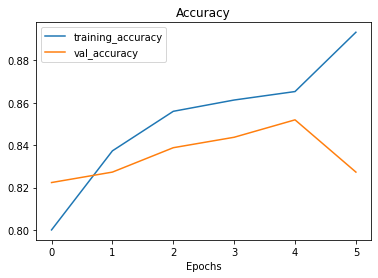

In [47]:
# Checkout the loss curves of our fine tuned model
plot_loss_curves(history_10_percent_aug_fine_tuned)

The plot loss curves function works great with model which have been fit once
however model 3 has been fit a second time

In [48]:
# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects
  """
  # Get original history measurement
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Val accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")

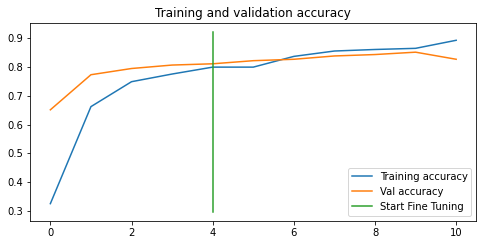

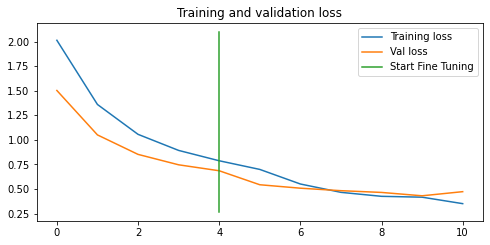

In [49]:
compare_history(history_10_percent_augmented, history_10_percent_aug_fine_tuned, 5)

## Model 4: Fine-tuning an existing model on all of our data

In [50]:
# Download and unzip 10 classes of food 101 data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-06-07 21:45:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.192.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   127MB/s    in 4.4s    

2022-06-07 21:45:37 (114 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [51]:
# Setup training and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [52]:
# How many images do we have
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [53]:
from tensorflow.python.ops.gen_batch_ops import Batch
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments

In [54]:
# Evaluate model 2 (fine tune 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.5009 - accuracy: 0.8240


[0.5009303092956543, 0.8240000009536743]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extraction weights

In [55]:
# Load weights from checkpoint, that way we can fine tune from the same stage the 10 percent model was fine tuned from
model_2.load_weights(checkpoint_path)

In [56]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6861 - accuracy: 0.8116


[0.6861260533332825, 0.8116000294685364]

In [57]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [58]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [59]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

history_full_data_fine = model_2.fit(train_data,
                                epochs=10,    
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                initial_epoch=history_10_percent_augmented.epoch[-1], # Start training from previous last epoch
                                callbacks=[create_tensorboard_callback("tensorflow_hub", "100_percent_fine_tune_last_10")])

Saving TensorBoard log files to: tensorflow_hub/100_percent_fine_tune_last_10/20220607-214557
Epoch 5/10
235/235 [==============================] - 65s 251ms/step - loss: 0.7160 - accuracy: 0.7731 - val_loss: 0.4426 - val_accuracy: 0.8405
Epoch 6/10
235/235 [==============================] - 47s 199ms/step - loss: 0.5830 - accuracy: 0.8065 - val_loss: 0.3861 - val_accuracy: 0.8684
Epoch 7/10
235/235 [==============================] - 44s 183ms/step - loss: 0.5154 - accuracy: 0.8331 - val_loss: 0.3638 - val_accuracy: 0.8799
Epoch 8/10
235/235 [==============================] - 43s 181ms/step - loss: 0.4787 - accuracy: 0.8432 - val_loss: 0.3249 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 39s 165ms/step - loss: 0.4350 - accuracy: 0.8611 - val_loss: 0.3286 - val_accuracy: 0.8816
Epoch 10/10
235/235 [==============================] - 35s 145ms/step - loss: 0.4047 - accuracy: 0.8661 - val_loss: 0.3277 - val_accuracy: 0.8816


In [60]:
# Evaluate the model
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.3269 - accuracy: 0.8848


[0.3268773555755615, 0.8848000168800354]

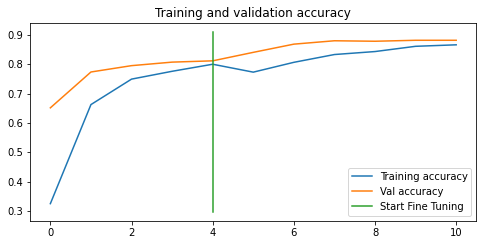

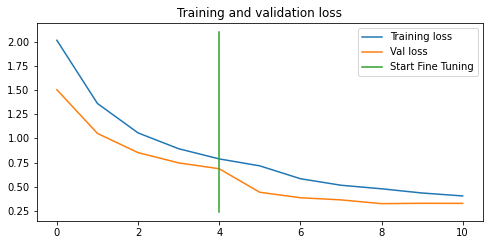

In [61]:
compare_history(history_10_percent_augmented, history_full_data_fine, 5)

## Viewing our experiment data on TensorBoard

In [62]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of transfer learning experiments" \
  --one_shot # exits the uploader


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [87]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# 2. Freeze the base model (Model's patterns won't be updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

# 4. If usinga model like ResNet50V2 you will need to normalize (don't have to for efficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs, training=False)
print(f"Shape after passing the inputs: {x.shape}")

# 6. Average the ouputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Create the model
model_3 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_3 = model_3.fit(train_data_10_percent,
                        epochs=10,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[checkpoint_callback])

Shape after passing the inputs: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/10
23/24 [===========================>..] - ETA: 0s - loss: 1.8480 - accuracy: 0.4402
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 306ms/step - loss: 1.8362 - accuracy: 0.4467 - val_loss: 1.3211 - val_accuracy: 0.7171
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.0825 - accuracy: 0.7609
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 236ms/step - loss: 1.0814 - accuracy: 0.7587 - val_loss: 0.9052 - val_accuracy: 0.8125
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7846 - accuracy: 0.8152
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 257ms/step - loss: 0.7869 - accuracy: 0.8147 - val_loss: 0.7328 - val_accu

In [88]:
model_3.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4932 - accuracy: 0.8528


[0.4931793510913849, 0.8528000116348267]

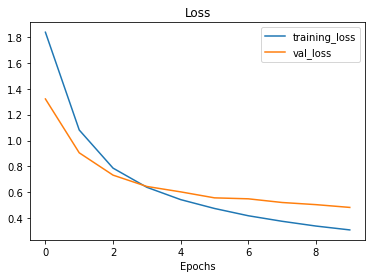

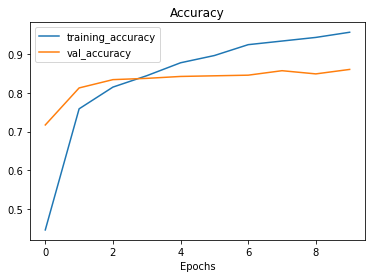

In [89]:
plot_loss_curves(history_3)

In [99]:
model_3.load_weights(checkpoint_path)
model_3.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.4932 - accuracy: 0.8528


[0.4931792616844177, 0.8528000116348267]

In [100]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

history_3_fine_20 = model_3.fit(train_data,
                                epochs=20,
                                initial_epoch=history_3.epoch[-1],
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)))

Epoch 10/20
235/235 [==============================] - 31s 110ms/step - loss: 0.4734 - accuracy: 0.8551 - val_loss: 0.3297 - val_accuracy: 0.8865
Epoch 11/20
235/235 [==============================] - 21s 89ms/step - loss: 0.3147 - accuracy: 0.9031 - val_loss: 0.2950 - val_accuracy: 0.8980
Epoch 12/20
235/235 [==============================] - 24s 100ms/step - loss: 0.2216 - accuracy: 0.9315 - val_loss: 0.2898 - val_accuracy: 0.9013
Epoch 13/20
235/235 [==============================] - 30s 123ms/step - loss: 0.1512 - accuracy: 0.9585 - val_loss: 0.2762 - val_accuracy: 0.9046
Epoch 14/20
235/235 [==============================] - 27s 108ms/step - loss: 0.0954 - accuracy: 0.9773 - val_loss: 0.3236 - val_accuracy: 0.8997
Epoch 15/20
235/235 [==============================] - 21s 89ms/step - loss: 0.0555 - accuracy: 0.9892 - val_loss: 0.3168 - val_accuracy: 0.9161
Epoch 16/20
235/235 [==============================] - 21s 90ms/step - loss: 0.0300 - accuracy: 0.9960 - val_loss: 0.2759 - va

In [101]:
# Evaluate the model
model_3.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4003 - accuracy: 0.9192


[0.40030592679977417, 0.9192000031471252]

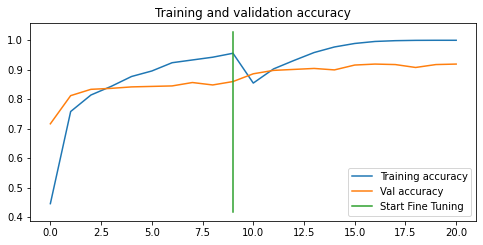

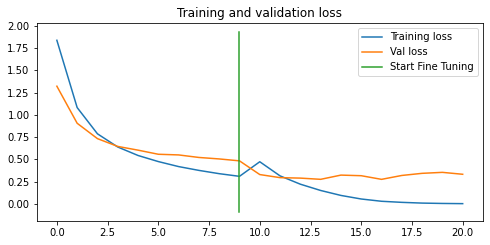

In [102]:
# plot curves
compare_history(history_3, history_3_fine_20, 10)

In [95]:
model_3.load_weights(checkpoint_path)
model_3.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.4932 - accuracy: 0.8528


[0.4931792914867401, 0.8528000116348267]

In [96]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

history_3_fine_30 = model_3.fit(train_data,
                                epochs=20,
                                initial_epoch=history_3.epoch[-1],
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)))

Epoch 10/20
235/235 [==============================] - 31s 99ms/step - loss: 0.4720 - accuracy: 0.8549 - val_loss: 0.3560 - val_accuracy: 0.8849
Epoch 11/20
235/235 [==============================] - 22s 92ms/step - loss: 0.3045 - accuracy: 0.9065 - val_loss: 0.2802 - val_accuracy: 0.9030
Epoch 12/20
235/235 [==============================] - 22s 93ms/step - loss: 0.2048 - accuracy: 0.9380 - val_loss: 0.3071 - val_accuracy: 0.9079
Epoch 13/20
235/235 [==============================] - 22s 92ms/step - loss: 0.1253 - accuracy: 0.9657 - val_loss: 0.2981 - val_accuracy: 0.9079
Epoch 14/20
235/235 [==============================] - 22s 93ms/step - loss: 0.0682 - accuracy: 0.9856 - val_loss: 0.3369 - val_accuracy: 0.9030
Epoch 15/20
235/235 [==============================] - 22s 93ms/step - loss: 0.0317 - accuracy: 0.9956 - val_loss: 0.3715 - val_accuracy: 0.9030
Epoch 16/20
235/235 [==============================] - 22s 93ms/step - loss: 0.0132 - accuracy: 0.9988 - val_loss: 0.3992 - val_ac

In [97]:
model_3.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5070 - accuracy: 0.9096


[0.506973922252655, 0.909600019454956]

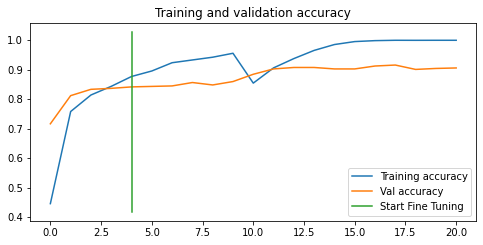

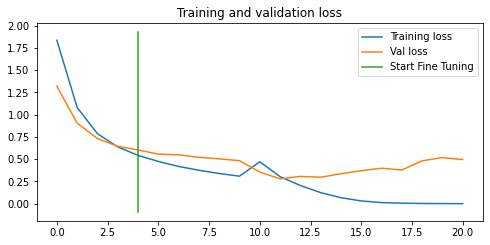

In [98]:
compare_history(history_3, history_3_fine_30)

In [164]:
# Create a function to import an image and resize it to be able to use it with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into tensor and reshape it
  to (img_shape, img_shape, colour_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all value between 0 and 1)
  #img = img/255.
  return img

In [175]:
import numpy as np

def pred_and_plot(filename, model, class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plot the image with the predicted class as the title
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  # Add in logic for multi-class & get pred class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
    prob = round(pred[0][tf.argmax(pred[0])]*100,2)
  else:
    pred_class = class_names[int(tf.round(pred))]
    if int(tf.round(pred)) == 1:
      prob = round(pred[0,0]*100, 2)
    else:
      prob = round((1 - pred[0,0])*100,2)

  # Plot the image
  plt.imshow(img/255.)
  plt.title(f"Prediction: {pred_class}, confidence: {prob}%")
  plt.axis(False)

[[2.18966397e-06 2.41204257e-09 1.35923599e-07 4.11252421e-10
  6.51048185e-06 4.90612967e-11 9.99991059e-01 1.02950075e-08
  4.05162570e-09 5.58116975e-09]]


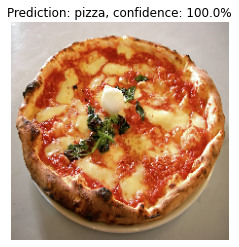

In [176]:
pred_and_plot("/content/Eq_it-na_pizza-margherita_sep2005_sml.jpg", model=model_3, class_names = train_data.class_names)

[[4.4287034e-28 1.7253532e-25 1.5247843e-21 2.4796885e-18 4.5393695e-20
  2.5093616e-23 7.0601980e-27 2.9307098e-23 4.8275754e-23 1.0000000e+00]]


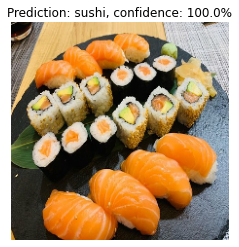

In [177]:
pred_and_plot("/content/sushi-place.jpg", model=model_3, class_names = train_data.class_names)

[[9.9831867e-01 5.9064984e-09 5.2467227e-04 6.9328473e-04 3.5268031e-13
  1.2193236e-07 1.7537131e-10 2.2272011e-09 3.6207200e-06 4.5970766e-04]]


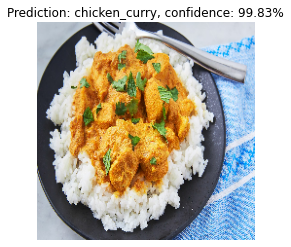

In [180]:
pred_and_plot("/content/190509-coconut-chicken-curry-157-1558039780.jpg", model=model_3, class_names = train_data.class_names)